# Table of Contents

1. [Importing Libraries](#1.-Importing-Libraries)
2. [Getting the data](#2.-Getting-the-data)
3. [Config and Functions](#3.-Config-and-Functions) \
    3.1 [Config](#3.1-Config) \
    3.2 [Functions](#3.2-Functions)
4. [Visualization](#4.-Visualization) \
    4.1 [Largest producers / consumer per commodity](#Largest-producers-/-consumer-per-commodity) \
    4.2 [Balance between production and consumption in respective origin countries]() \
    4.3 [Stock level balance throughout the years]()

# 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# 2. Getting the data

In [2]:
# commodities_link = 'https://apps.fas.usda.gov/psdonline/downloads/psd_alldata_csv.zip'
commodities_file = 'data/psd_alldata_csv.zip'

all_commodities = pd.read_csv(commodities_file, 
                              compression='zip',
                              keep_default_na=False)

In [3]:
commodities_to_explore = \
    ['Grapefruit, Fresh',
     'Lemons/Limes, Fresh',
     'Oranges, Fresh',
     'Tangerines/Mandarins, Fresh',
     'Coffee, Green']

commodities = (all_commodities
                   [all_commodities.Commodity_Description.isin(commodities_to_explore)]
                   .copy()
                   .reset_index())

# 3. Config and Functions 

## 3.1 Config

In [5]:
# dataframe style
heading_properties = [('font-size', '16px')]
cell_properties = [('font-size', '15px')]
dfstyle = [dict(selector="th", props=heading_properties),
           dict(selector="td", props=cell_properties)]


## 3.2 Functions

In [169]:
# manipulation

def filter_by_values(df: pd.DataFrame, column: str, values: list):
    
    return df[df[column].isin(values)].copy()


def groupby_and_sum_values(df: pd.DataFrame, group: list):
        
    return df.groupby(group).sum('Value')[['Value']]


def get_top_countries_per_commodity(df_attr: pd.DataFrame, column_title: str):

    commodities_sum_value_per_country = \
        groupby_and_sum_values(df_attr, ['Commodity_Description', 'Country_Name'])

    commodities_max_values = \
        commodities_sum_value_per_country.groupby(['Commodity_Description']).max()#idxmax()

    return (commodities_max_values
                .merge(commodities_sum_value_per_country.reset_index())
                .rename(columns={'Commodity_Description': 'Commodity',
                                 'Country_Name': column_title})
                .sort_values(column_title)
                .drop('Value', axis=1))


def get_production_consumption_from_producers(df_production: pd.DataFrame,
                                              df_consumption: pd.DataFrame):

    production_per_country = \
        (groupby_and_sum_values(df_production,
                                ['Commodity_Description', 'Country_Name'])
            .rename(columns={'Value': 'Production'}))

    consumption_per_country = \
        (groupby_and_sum_values(df_consumption,
                               ['Commodity_Description', 'Country_Name'])
            .rename(columns={'Value': 'Consumption'}))

    production_consumption_per_country = \
        production_per_country.join(consumption_per_country)

    return (production_consumption_per_country
                [production_consumption_per_country.Production != 0])


def calculate_production_consumption_percentage(df_prod_cons: pd.DataFrame):
    
    return round((df_prod_cons['Consumption'] 
                  / df_prod_cons['Production'])*100, 
                 2)


def calculate_production_consumption_balance(df_prod_cons: pd.DataFrame):
    
    return round((df_prod_cons['Production']
                  / df_prod_cons['Consumption']),
                 2)

In [45]:
#visualization

def stylize_df_top_country_per_commodity(df: pd.DataFrame, highlight_columns: list):
    
    return (df#.drop('Value', axis=1)
              .style
                  .set_table_styles(dfstyle)
                  .set_properties(**{'background-color': '#ffffb3', 
                                     'text-align': 'left'}, 
                                  subset=highlight_columns)
              .hide_index())

# 4. Visualization

## 4.1 Largest producers / consumer per commodity

##### Largest Producers per Commodity

In [71]:
commodities_production = \
    filter_by_values(df=commodities, 
                     column='Attribute_Description', 
                     values=['Production'])

# commodities_production.head()

- checking if each commodity has only one type of unit. In this way we can sum or compare countries more fairly:

In [72]:
commodities.groupby('Commodity_Description')['Unit_Description'].unique()

Commodity_Description
Coffee, Green                  [(1000 60 KG BAGS)]
Grapefruit, Fresh                      [(1000 MT)]
Lemons/Limes, Fresh                    [(1000 MT)]
Oranges, Fresh                         [(1000 MT)]
Tangerines/Mandarins, Fresh            [(1000 MT)]
Name: Unit_Description, dtype: object

In [138]:
largest_producers_per_commodity = \
    get_top_countries_per_commodity(commodities_production, 
                                    'Largest Producer')

# largest_producers_per_commodity

##### Largest Consumer per Commodity

In [74]:
commodities_consumption = \
    filter_by_values(df=commodities, 
                     column='Attribute_Description',
                     values=['Domestic Consumption', 'Fresh Dom. Consumption'])

# commodities_consumption.head()

In [75]:
largest_consumers_per_commodity = \
    get_top_countries_per_commodity(commodities_consumption, 
                                    'Largest Consumer')

# largest_consumers_per_commodity

##### Largest producers / consumer per commodity

In [76]:
largest_consumers_producers_per_commodity = \
    (largest_producers_per_commodity
         .merge(largest_consumers_per_commodity, 
                on='Commodity'))

stylize_df_top_country_per_commodity(largest_consumers_producers_per_commodity,
                                     ['Largest Producer', 'Largest Consumer'])

Commodity,Largest Producer,Largest Consumer
"Coffee, Green",Brazil,European Union
"Oranges, Fresh",Brazil,Brazil
"Tangerines/Mandarins, Fresh",China,China
"Lemons/Limes, Fresh",Mexico,European Union
"Grapefruit, Fresh",United States,China


## 4.2  Balance between production and consumption in respective origin countries

In [159]:
commodities_production_2020 = \
    filter_by_values(commodities_production, 'Market_Year', [2020])

commodities_consumption_2020 = \
    filter_by_values(commodities_consumption, 'Market_Year', [2020])

In [170]:
production_consumption_per_country = \
    get_production_consumption_from_producers(df_production=commodities_production_2020, 
                                              df_consumption=commodities_consumption_2020)

production_consumption_per_country['Prod/Cons'] = \
    calculate_production_consumption_balance(production_consumption_per_country)

production_consumption_per_country.tail(25)

Production  Consumption  Prod/Cons
Commodity_Description       Country_Name                                      
Oranges, Fresh              Guatemala            180.0        220.0       0.82
                            Iraq                  75.0        205.0       0.37
                            Israel                58.0         27.0       2.15
                            Japan                  6.0         98.0       0.06
                            Malaysia              13.0         99.0       0.13
                            Mexico              4010.0       1975.0       2.03
                            Morocco             1100.0        900.0       1.22
                            Mozambique            68.0         73.0       0.93
                            South Africa        1700.0         80.0      21.25
                            Turkey              1360.0       1036.0       1.31
                            United States       4113.0       1248.0       3.30
                            Vietnam              770.0        820.0       0.94
Tangerines/Mandarins, Fresh Argentina            360.0        220.0       1.64
                            Australia            175.0         96.0       1.82
                            China              23120.0      21860.0       1.06
                            European Union      3117.0       3097.0       1.01
                            Israel               160.0         40.0       4.00
                            Japan                973.0        923.0       1.05
                            Korea, South         660.0        567.0       1.16
                            Morocco             1205.0        705.0       1.71
                            Philippines           12.0        127.0       0.09
                            South Africa         515.0         30.0      17.17
                            Thailand             135.0        225.0       0.60
                            Turkey              1750.0        788.0       2.22
                            United States        882.0       1012.0       0.87

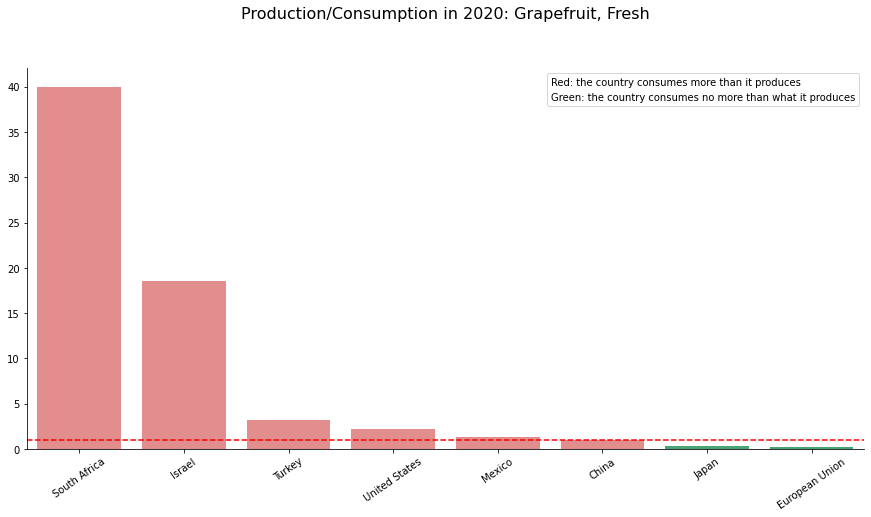

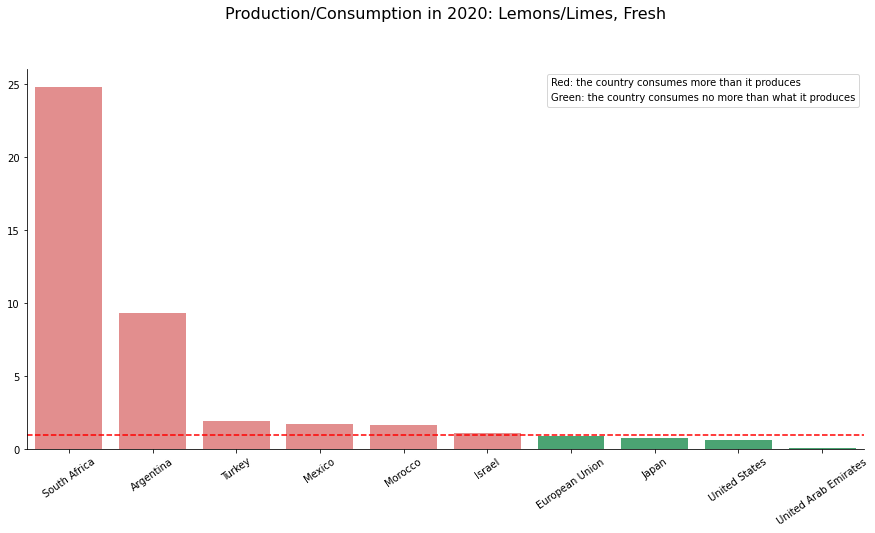

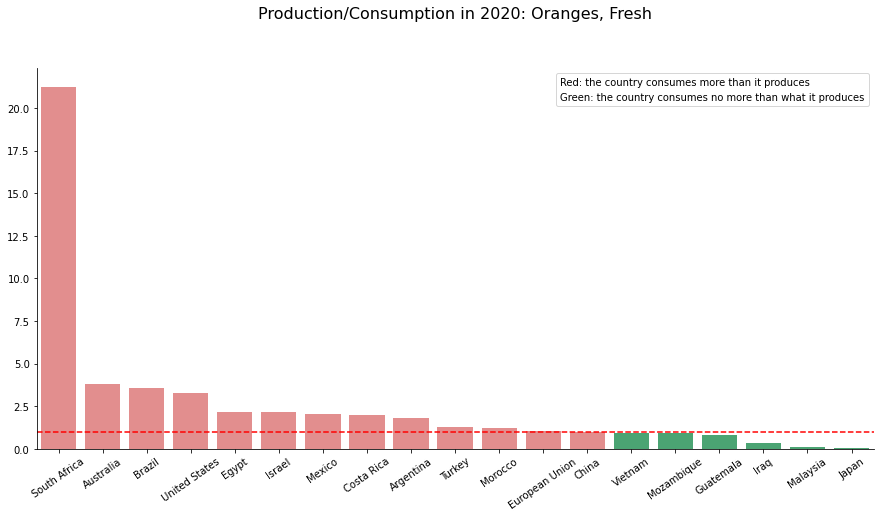

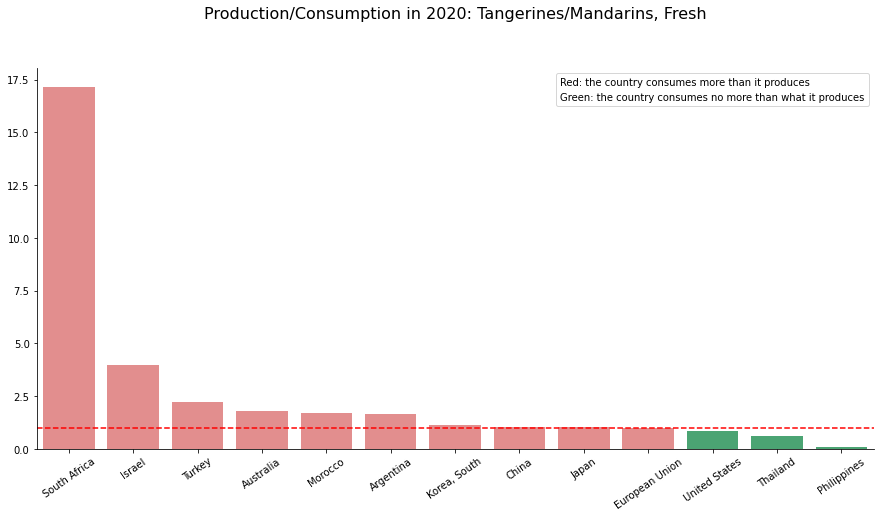

In [275]:
for commodity in commodities_to_explore[:-1]:
    
    data = (production_consumption_per_country
                .loc[commodity]
                .copy()
                .reset_index()
                .sort_values('Prod/Cons', ascending=False))
    
    plt.figure(figsize=(15,7))
    
    sns.barplot(data=data, x='Country_Name', y='Prod/Cons',
                palette=["mediumseagreen" if x<=1.0 else 'lightcoral' for x in data['Prod/Cons']])
    
    sns.despine()
    
    plt.xticks(rotation=35)
    plt.xlabel('')
    plt.ylabel('')
    plt.title("Production/Consumption in 2020: "+commodity, fontsize=16, pad=50)
    plt.axhline(y=1, color='red', linestyle='--') 
    
    plt.legend(['Red: the country consumes more than it produces',
                'Green: the country consumes no more than what it produces'],
               handlelength=0, handletextpad=0)
    
    plt.show();

    
# separar em dois gráficos: países que consomem mais do que produzem vs países que produzem mais do que consomem

## 4.3 Stock level balance throughout the years